In [39]:
#@title Imports and Helper Functions
import numpy as np
from matplotlib import pyplot as plt

class Model:
    """Base class for models."""
    def __init__(self):
        """params is a dictionary mapping parameter names to numpy arrays"""
        self.params = {}

    def predict(self, X):
        """X is a numpy array of shape (N, D), where N is the number of
        D-dimensional data points"""
        raise NotImplementedError

    def loss(self, X, y):
        """X is a numpy array of shape (N, D) and y is a numpy array of shape (N,)"""
        raise NotImplementedError

    def grad(self, X, y):
        """X is a numpy array of shape (N, D) and y is a numpy array of shape (N,).
        This will be a matching dictionary to self.params, with all the same keys
        and for each parameter it will have the gradient which is a numpy array of
        the same shape"""
        raise NotImplementedError

def grad_check(model, X, y, eps = 1e-6):
    """Numerically estimate the gradient of the loss function and compare it to the analytical gradient"""
    grad = model.grad(X, y)
    for param in model.params:
        print(f"Checking {param}:")
        print(f"Analytical gradient {grad[param]}")
        numgrad = np.zeros(grad[param].shape)
        for i, val in np.ndenumerate(model.params[param]):
            model.params[param][i] = val + eps
            loss1 = model.loss(X, y)
            model.params[param][i] = val - eps
            loss2 = model.loss(X, y)
            model.params[param][i] = val
            numgrad[i] = (loss1 - loss2) / (2 * eps)
        print(f"Numerical gradient {numgrad}")
        print(f"Difference {abs(numgrad - grad[param])}")
        print()

class Optimizer:
    def __init__(self, model):
        self.model = model

    def step(self, grad):
        raise NotImplementedError

class SGD(Optimizer):
    def __init__(self, model, learning_rate=1e-3):
        super().__init__(model)
        self.learning_rate = learning_rate

    def step(self, grad):
        for param in self.model.params:
            self.model.params[param] -= self.learning_rate * grad[param]

def train(model, X, y, num_iterations = 100, print_every = 1, optimizer = None):
    """Simple training loop, with no batching."""
    if optimizer is None:
        optimizer = SGD(model)
    for i in range(num_iterations):
        optimizer.step(model.grad(X, y))
        if i % print_every == 0:
            print(f"Iteration {i}: loss {model.loss(X, y)}")

class MultipleRegression(Model):
    def __init__(self, D, reg=0):
        super().__init__()
        W = np.zeros(D, dtype=float)
        b = np.array(0, dtype=float)
        self.reg = reg
        self.params = {"W": W, "b": b}

    def predict(self, X):
        return X @ self.params['W'] + self.params['b']



    def loss(self,X,y):
        loss = np.mean((self.predict(X) - y) ** 2)
        loss += self.reg * np.sum(self.params['W'] ** 2)
        return loss

    def grad(self, X, y):
        dW = np.mean(2*X*(X@self.params['W']+self.params['b']-y).reshape((len(X),1)),axis=0)+self.reg*2*(self.params['W'])
        db = np.mean(2*(X@self.params['W']+self.params['b']-y))
        return {"W": dW, "b": db}

    def exact(self,X,y):
        # Add bias row
        newX = np.concatenate((X,np.ones(len(X)).reshape((len(X),1))),axis=1)

        # Create identity matrix for reg term
        idenmatrix = np.identity(len(self.params['W'])+1)
        idenmatrix[len(self.params['W']),len(self.params['W'])]=0

        # Regularization term
        regterm = len(X)*self.reg*idenmatrix

        # Get the answer
        explicit=np.linalg.inv(newX.T @ newX + regterm) @ newX.T @ y
        return {"W":explicit[:-1], "b":explicit[-1]}


# Part 1: Multiple Linear Regression

## Small Toy Example

In [40]:
X = np.array([[1,1],
              [1,2],
              [2,1],
              [2,2]], dtype=float)
y = np.array([0,1,2,2], dtype=float)

In [41]:
m = MultipleRegression(2)
grad_check(m, X, y)

Checking W:
Analytical gradient [-4.5 -4. ]
Numerical gradient [-4.5 -4. ]
Difference [1.84911642e-10 1.07021947e-10]

Checking b:
Analytical gradient -2.5
Numerical gradient -2.5000000001274003
Difference 1.2740031252178596e-10



In [42]:
m = MultipleRegression(2, reg = 0.5)
m.params['W'] = np.array([0.,1.])
m.params['b'] = np.array(-1.)
grad_check(m, X, y)

Checking W:
Analytical gradient [-3. -1.]
Numerical gradient [-3. -1.]
Difference [2.47553089e-11 8.22666379e-11]

Checking b:
Analytical gradient -1.5
Numerical gradient -1.500000000209667
Difference 2.0966695046809036e-10



Once you get the gradient working, find the optimal weight and biases for reg = 0 and reg = 0.5

In [48]:
# Calculate for reg=0 and reg=0.5
model0 = MultipleRegression(2,reg=0)
model05 = MultipleRegression(2,reg=0.5)
train(model0,X,y,num_iterations=100000,print_every=7894107498372901485)
train(model05,X,y,num_iterations=100000,print_every=492719804739805794823)
print()
print("Optimal solution for reg=0: "+str(model0.params))
print("Loss for reg=0: "+str(model0.loss(X,y)))
print()
print("Optimal solution for reg=0.5: "+str(model05.params))
print("Loss for reg=0.5: "+str(model05.loss(X,y)))

Iteration 0: loss 2.2077416249999997
Iteration 0: loss 2.2077597499999997

Optimal solution for reg=0: {'W': array([1.49990106, 0.49990106]), 'b': array(-1.74968957)}
Loss for reg=0: 0.06250000508000032

Optimal solution for reg=0.5: {'W': array([0.5       , 0.16666667]), 'b': array(0.25)}
Loss for reg=0.5: 0.47916666666666674


## Class Generated Dataset

We will generate some data for each student in [this spreadsheet](https://docs.google.com/spreadsheets/d/1EpaWo2nuFtpXYFGblQ7FL-ADqhapAO5ISn51CLg2dfY/edit?usp=sharing)

Use it to create an X and y for multiple regression

In [44]:
import csv
Xclass = []
yclass = []
top = True

with open('/content/Student Measurements - Sheet1.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        if not top:
          Xclass.append(row[2:])
          yclass.append(row[1])
        else:
          top = False

Xclass = np.array(Xclass).astype(float)
yclass = np.array(yclass).astype(float)

## Exact Solution

We will see again that this has an exact solution, and then add that capability so your model can directly fit X and y without actually having to do gradient descent

In [53]:
# Exact solution for toy dataset

# Solution for reg=0
print("Exact Solution for reg=0:")
modelnew = MultipleRegression(2)
print(modelnew.exact(X,y))
modelnew.params = modelnew.exact(X,y)
print("Loss for reg=0: "+str(modelnew.loss(X,y)))
print()

# Solution for reg=0.5
print("Exact Solution for reg=0.5:")
modelnew05 = MultipleRegression(2,reg=0.5)
print(modelnew05.exact(X,y))
modelnew05.params = modelnew05.exact(X,y)
print("Loss for reg=0.5: "+str(modelnew05.loss(X,y)))
print()

Exact Solution for reg=0:
{'W': array([1.5, 0.5]), 'b': -1.7500000000000053}
Loss for reg=0: 0.06250000000000006

Exact Solution for reg=0.5:
{'W': array([0.5       , 0.16666667]), 'b': 0.25000000000000044}
Loss for reg=0.5: 0.47916666666666674



In [50]:
# Optimizer on Class dataset
print(Xclass, yclass)
model0 = MultipleRegression(4,reg=0)
model05 = MultipleRegression(4,reg=0.5)
train(model0,Xclass,yclass,num_iterations=100000,print_every=7894107498372901485,optimizer=SGD(model0, learning_rate=0.00001))
train(model05,Xclass,yclass,num_iterations=100000,print_every=492719804739805794823,optimizer=SGD(model05, learning_rate=0.00001))
print()
print("Optimal solution for reg=0: "+str(model0.params))
print("Loss for reg=0: "+str(model0.loss(Xclass,yclass)))
print()
print("Optimal solution for reg=0.5: "+str(model05.params))
print("Loss for reg=0.5: "+str(model05.loss(Xclass,yclass)))

[[ 15.02    10.     166.37    41.3   ]
 [ 16.86    16.     179.07    46.5   ]
 [ 17.21     9.     162.56    39.    ]
 [ 16.3036   8.     181.61    46.    ]
 [ 17.87    10.     162.56    39.    ]
 [ 17.14    13.     175.26    43.    ]
 [ 17.068    8.     171.45    44.    ]
 [ 18.05    11.     186.69    42.5   ]
 [ 32.34    12.     184.15    46.    ]] [167.64  182.88  173.99  179.705 168.275 172.72  181.4   181.61  189.   ]
Iteration 0: loss 3747.6157863704834
Iteration 0: loss 3747.82264173345

Optimal solution for reg=0: {'W': array([ 0.30072534, -0.475897  ,  0.73520419,  1.12043863]), 'b': array(0.36448343)}
Loss for reg=0: 23.205440447243753

Optimal solution for reg=0.5: {'W': array([ 0.29466682, -0.41311457,  0.7689009 ,  0.9705751 ]), 'b': array(0.36999717)}
Loss for reg=0.5: 24.176175147607122


In [54]:
# Exact solution for class dataset
# Solution for reg=0
print("Exact Solution for reg=0:")
modelnew = MultipleRegression(4)
print(modelnew.exact(Xclass,yclass))
modelnew.params = modelnew.exact(Xclass,yclass)
print("Loss for reg=0: "+str(modelnew.loss(Xclass,yclass)))
print()

# Solution for reg=0.5
print("Exact Solution for reg=0.5:")
modelnew05 = MultipleRegression(4,reg=0.5)
print(modelnew05.exact(Xclass,yclass))
modelnew05.params = modelnew05.exact(Xclass,yclass)
print("Loss for reg=0: "+str(modelnew05.loss(Xclass,yclass)))
print()

Exact Solution for reg=0:
{'W': array([ 0.49910282, -0.27983592,  0.26597351,  1.06536023]), 'b': 78.94065899594007}
Loss for reg=0: 9.14108649461049

Exact Solution for reg=0.5:
{'W': array([ 0.48912048, -0.23328713,  0.30096896,  0.9067452 ]), 'b': 79.34721111385556}
Loss for reg=0: 9.818818281210909



## Bonus: L1 Regularization
Instead of the regularization term using squares of weights, just use absolute value (L1 of W). Note there is no longer a closed form solution if we use this regularization term. How does this change the ultimate weights your model learns?

# Part 2: Polynomial Regression

In [27]:
#@title PolynomialRegression class

class PolynomialRegression(MultipleRegression):
    def __init__(self, degree, reg=0):
        super().__init__(degree, reg)
        self.degree = degree

    def transform(self, X):
        newX = X.reshape(len(X),1)
        fullthing = np.array([newX**i for i in range(1,self.degree+1)])
        if self.degree > 0:
          return np.concatenate(fullthing, axis=1)
        return fullthing.reshape((len(X),0))

    def predict(self, X):
        return super().predict(self.transform(X))

    def loss(self,X,y):
        return super().loss(X,y)

    def exact(self,X,y):
        return super().exact(self.transform(X),y)

    def plot(self, X, y):
        fig, ax = plt.subplots()
        ax.scatter(X, y)
        xlim = ax.get_xlim()
        xs = np.linspace(*xlim, 100)
        ax.plot(xs, self.predict(xs))

    def __str__(self):
        coefflist = [str(self.params['b'])]+[str(self.params['W'][w-1])+"x^"+str(w) for w in range(1,len(self.params['W'])+1)]
        return " + ".join(coefflist)

## Check on small data

Make a set of a few points (a single digit number).
Try fitting various curves with different amount of regularization. You should eventually see the polynomial perfectly fit your points.

Degree=0 Reg=0
Function: 3.6
Loss: 7.44


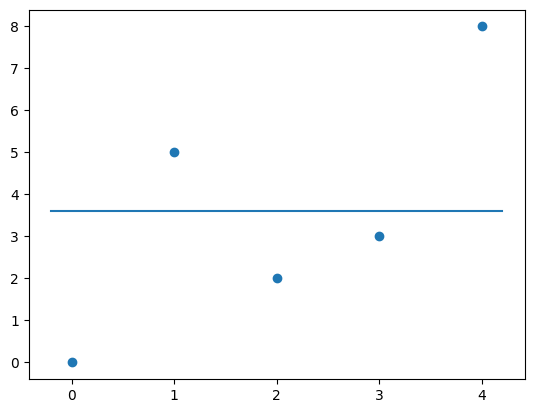


Degree=0 Reg=0.5
Function: 3.6
Loss: 7.44


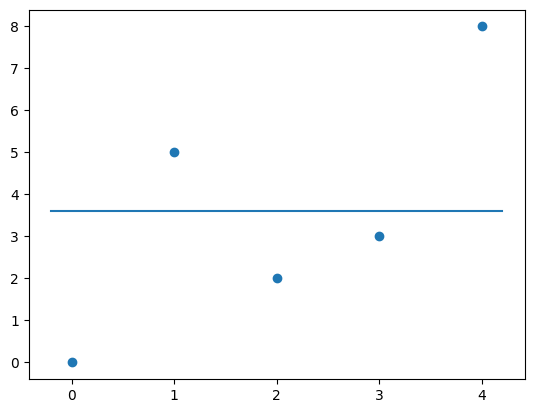


Degree=1 Reg=0
Function: 0.7999999999999998 + 1.4000000000000001x^1
Loss: 3.5199999999999996


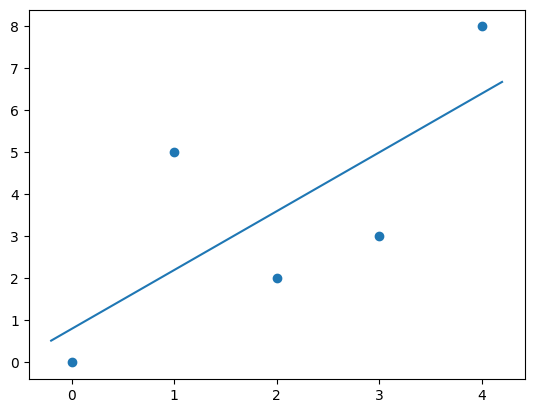


Degree=1 Reg=0.5
Function: 1.3599999999999999 + 1.1199999999999999x^1
Loss: 4.303999999999999


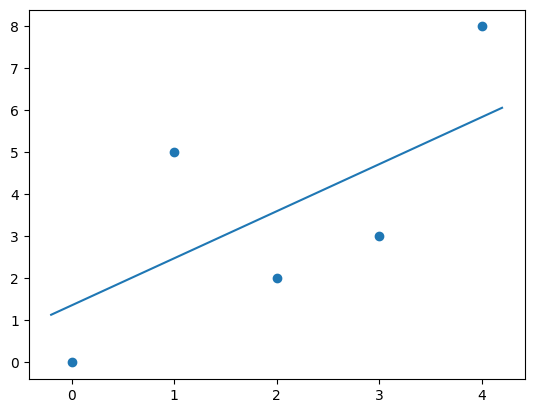


Degree=2 Reg=0
Function: 1.371428571428567 + 0.2571428571428638x^1 + 0.2857142857142825x^2
Loss: 3.291428571428572


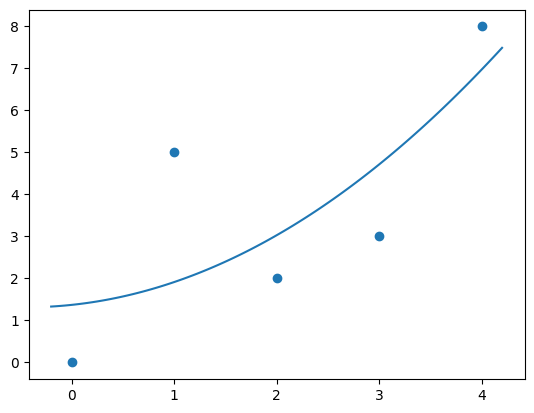


Degree=2 Reg=0.5
Function: 1.4853608247422683 + 0.11711340206185561x^1 + 0.3134020618556699x^2
Loss: 3.3512577319587633


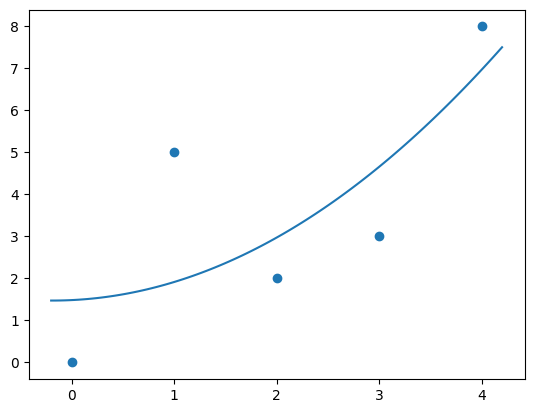


Degree=3 Reg=0
Function: 0.1714285714284679 + 8.857142857143467x^1 + -5.714285714286108x^2 + 1.0000000000000662x^3
Loss: 0.4114285714285706


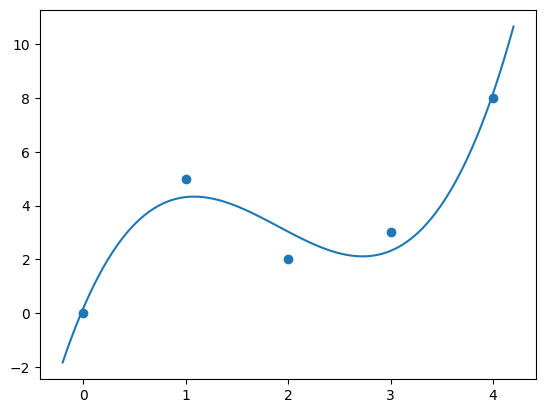


Degree=3 Reg=0.5
Function: 1.9271349410549978 + 0.3207222941609644x^1 + -0.3304893063210216x^2 + 0.15071781542745827x^3
Loss: 2.8513842284866198


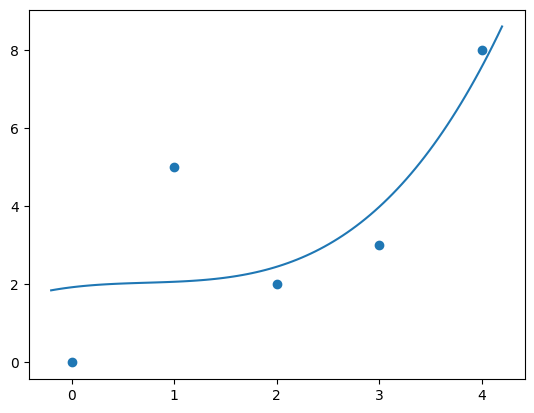


Degree=4 Reg=0
Function: 3.4783287361506154e-13 + 15.999999999986152x^1 + -15.49999999998823x^2 + 4.9999999999966285x^3 + -0.499999999999575x^4
Loss: 1.5618871863625366e-22


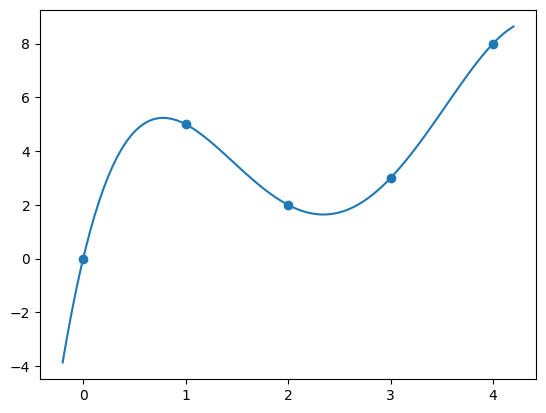


Degree=4 Reg=0.5
Function: 1.9886651360046608 + 0.5730905247724072x^1 + 0.1697099578780404x^2 + -0.3531543521497482x^3 + 0.0919488857369672x^4
Loss: 2.36359892281411


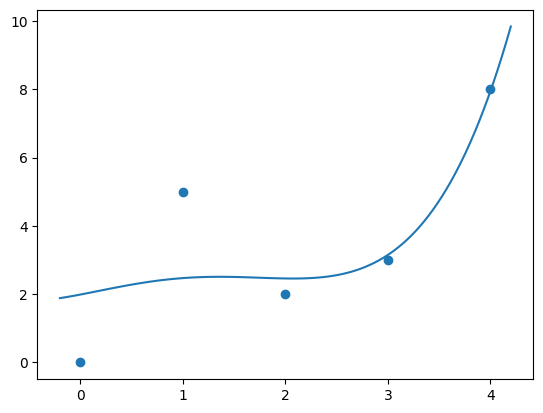


Degree=5 Reg=0
Function: -5.9539040364597895e-12 + -72.3874511721703x^1 + 76.93798828163504x^2 + -43.232666015777724x^3 + 12.590576171893696x^4 + -1.2653579711914062x^5
Loss: 2152.374606664046


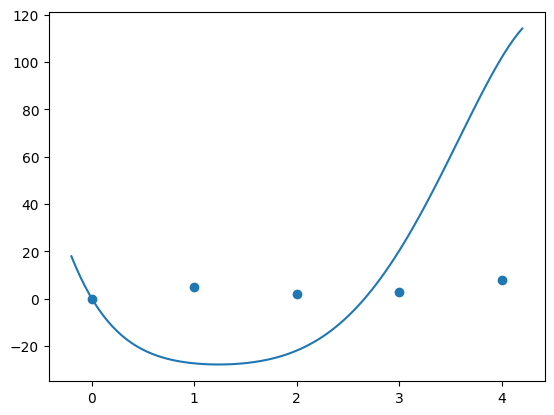


Degree=5 Reg=0.5
Function: 1.839003204821962 + 0.5499760275876342x^1 + 0.2799588191685644x^2 + -0.018776235564469196x^3 + -0.14195041340775078x^4 + 0.03618040694442172x^5
Loss: 2.218674386595171


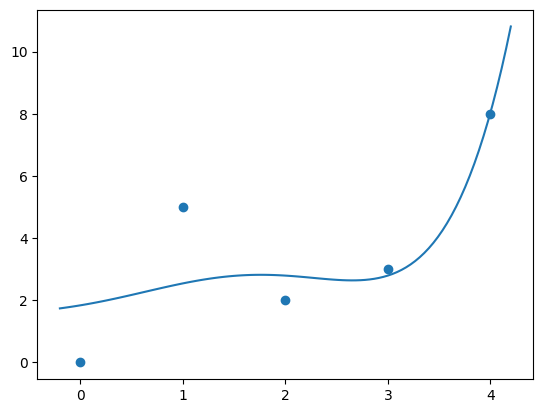

In [28]:
# Set of points
polyX=np.arange(0,5)
polyy=np.array([0,5,2,3,8])

for deg in range(0,6):
  for reg in [0,0.5]:
    print("Degree="+str(deg), "Reg="+str(reg))

    # Create and train model
    currmodel = PolynomialRegression(deg,reg=reg)
    currmodel.params = currmodel.exact(polyX,polyy)

    # Plot stuff
    currmodel.plot(polyX,polyy)
    print("Function: "+str(currmodel))
    print("Loss: "+str(currmodel.loss(polyX,polyy)))
    plt.show()
    print()

## Example: estimate constant of gravity

As a first test of your polynomial regression class, see if you can fit a quadratic to this data coming from a falling ball. Physics predicts it should be
$$h(t) = h_0 + v_0 \cdot t - \frac{g}{2} \cdot t^2,$$

where $g$ (in units of $m/s^2$) is Earth's gravitational constant, giving the rate of downward acceleration. Find the best quadratic to fit this data to estimate $g$.

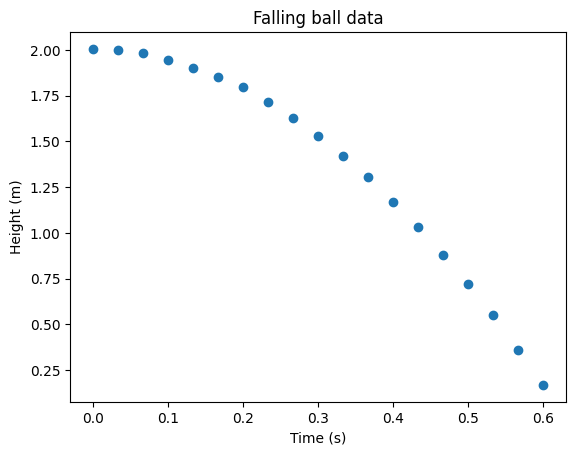

In [29]:
## data collected from https://www.youtube.com/watch?v=OEcyVzwciCs&ab_channel=ISLEPhysics

ygrav = np.array([200.5, 200, 198, 194.5, 190.2, 185, 179.5, 171.5, 163, 153, 142.2, 130.3, 117, 103, 88, 72, 55, 36, 17]) / 100
Xgrav = np.linspace(0, 0.6, len(ygrav))
plt.scatter(Xgrav, ygrav)
plt.xlabel('Time (s)')
plt.ylabel('Height (m)')
plt.title('Falling ball data')
plt.show()

Quadratic: 2.007813533834581 + -0.11658911985840958x^1 + -4.9190181335693035x^2
g = 9.838036267138607 m/s^2


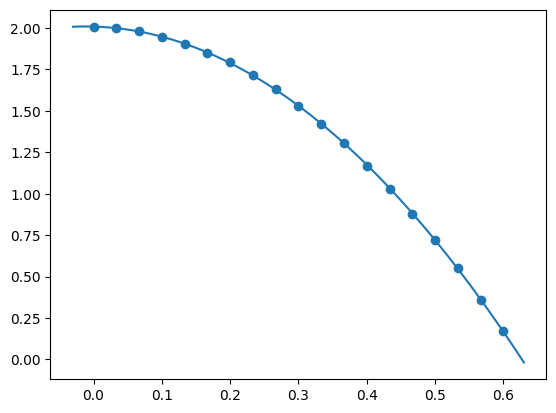

In [31]:
# Train model
gravity = PolynomialRegression(2)
gravity.params = gravity.exact(Xgrav,ygrav)

# Record stuff
gravity.plot(Xgrav,ygrav)
print("Quadratic: "+str(gravity))
print("g = "+str(-gravity.params['W'][-1]*2)+" m/s^2")

## Polynomial Fit Challenge

I generated some secret polynomials of unknown degree, and made some data coming from those polynomials plus noise. Try to see if you can choose the set of hyperparameters (find the degree, potentially also add some regularization) that you think fits this curve best. This should involve using a validation set, and because this dataset is pretty small, you should probably do k-fold cross validation.

Secret Polynomial 1
Degree: 3
Reg: 0
Function: -7.802974670912933 + 14.085959766455328x^1 + -7.184175868525639x^2 + 1.0385366858273768x^3
Loss: 0.04368872219141609


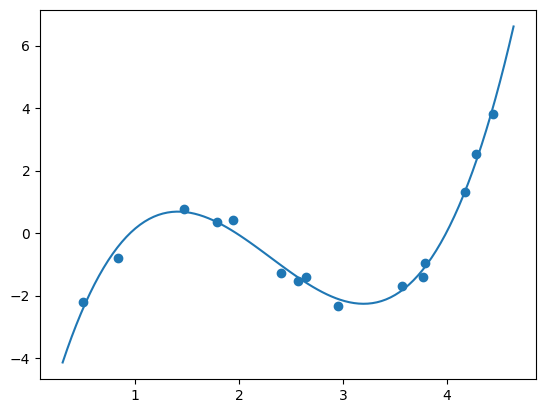


Secret Polynomial 2
Degree: 5
Reg: 0
Function: -45.01310124849957 + 132.1690416260088x^1 + -135.92319447426718x^2 + 59.8884811741928x^3 + -11.713657764054041x^4 + 0.8369124093012167x^5
Loss: 0.025939854810784025


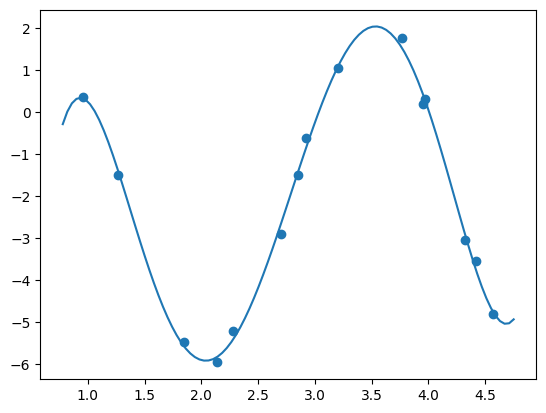

In [33]:
#@title Secret Polynomial Data
X1 = np.array([0.83970458, 2.40610534, 3.76390206, 1.94490536, 1.46855566,
        4.16853106, 3.5634144 , 3.79075211, 2.64154307, 0.50235891,
        4.27398109, 2.56718095, 1.78668299, 2.95250866, 4.44177834])
y1 = np.array([-0.7998434 , -1.27457238, -1.39327239,  0.40397065,  0.77856359,
         1.30030232, -1.69004943, -0.95285154, -1.40697462, -2.21800949,
         2.52442274, -1.52665889,  0.36616866, -2.33361331,  3.82489208])

X2 = np.array([1.26972919, 2.70559656, 3.95024355, 2.28282991, 1.84617602,
        4.32115347, 3.7664632 , 3.9748561 , 2.92141448, 0.96049567,
        4.417816  , 2.8532492 , 2.13779274, 3.20646627, 4.57163015])
y2 = np.array([-1.49414272, -2.90793443,  0.18976953, -5.20970387, -5.46367805,
        -3.03467102,  1.74949701,  0.31525131, -0.62679552,  0.34966043,
        -3.54403658, -1.4938531 , -5.95457108,  1.04509299, -4.79711428])

# Best for polynomial 1
# Used to choose the val sets for k-fold
valsource = np.random.permutation(np.arange(len(X1)))

# records the best one
bestparams = None
bestloss = None
for degree in [3,4,5,6,7,8]:
  for reg in [0,0.25,0.5]:
    currloss = 0

    # calculates the loss for each fold
    for fold in range(0,len(valsource),3):
      # train and val set
      trainset = np.concatenate((valsource[:fold],valsource[fold+3:]))
      valset = valsource[fold:fold+3]

      # trains model
      trainpoly = PolynomialRegression(degree,reg=reg)
      trainpoly.params = trainpoly.exact(X1[trainset],y1[trainset])

      # records loss
      currloss += trainpoly.loss(X1[valset],y1[valset])

    if bestloss is None or bestloss > currloss:
      bestloss = currloss
      bestparams = (degree, reg)

# creates the final model
best1poly = PolynomialRegression(bestparams[0],reg=bestparams[1])
best1poly.params = best1poly.exact(X1,y1)

# records stuff
print("Secret Polynomial 1")
print("Degree: "+str(best1poly.degree))
print("Reg: "+str(best1poly.reg))
print("Function: "+str(best1poly))
print("Loss: "+str(best1poly.loss(X1,y1)))
best1poly.plot(X1,y1)
plt.show()
print()

# Best for polynomial 2 - basically the same thing
valsource = np.random.permutation(np.arange(len(X2)))
bestparams = None
bestloss = None
for degree in [3,4,5,6,7,8]:
  for reg in [0,0.25,0.5]:
    currloss = 0
    for fold in range(0,len(valsource),3):
      trainset = np.concatenate((valsource[:fold],valsource[fold+3:]))
      valset = valsource[fold:fold+3]
      trainpoly = PolynomialRegression(degree,reg=reg)
      trainpoly.params = trainpoly.exact(X2[trainset],y2[trainset])
      currloss += trainpoly.loss(X2[valset],y2[valset])

    if bestloss is None or bestloss > currloss:
      bestloss = currloss
      bestparams = (degree, reg)

best2poly = PolynomialRegression(bestparams[0],reg=bestparams[1])
best2poly.params = best2poly.exact(X2,y2)

print("Secret Polynomial 2")
print("Degree: "+str(best2poly.degree))
print("Reg: "+str(best2poly.reg))
print("Function: "+str(best2poly))
print("Loss: "+str(best2poly.loss(X2,y2)))
best2poly.plot(X2,y2)
plt.show()
print()

# Sources and Reflection
https://www.geeksforgeeks.org/using-numpy-to-convert-array-elements-to-float-type/
https://numpy.org/devdocs/reference/generated/numpy.concatenate.html
https://numpy.org/devdocs/reference/generated/numpy.identity.html
https://numpy.org/doc/2.0/reference/random/generated/numpy.random.permutation.html